In [1]:
import numpy as np
import math
import os
import random
import queue
import matplotlib.pyplot as pl
from IPython.display import Image
from queue import Queue
import seaborn as sns
import time

# First Come First Serve Scheduling Algorithm

In [2]:
# def find waiting_time()

def turn_around_time(ct,arrival,tat):
    for i in range(len(ct)):
        tat[i]=ct[i]-arrival[i]
#Formula for Turn Around Time.
        
def waiting_time(tat,burst,wt):
    for i in range(len(tat)):
        wt[i]=tat[i]-burst[i]
#This is formula for waiting time of each process.

def find_burst_time(burst,burst_,n):
    burst_[0]=0
    for i in range(1,n):
        burst_[i]=burst[i-1]
#This is formula for calculating burst time of each process.

def find_completion_time(processes,process,arrival,burst,ct,n):
    availabele_time=0 #This is the total time that takes place
#From the begining when a process starts to keep track of how much time
# was spent for particular process. This is done to check for CPU idle if any.
    
    availabele_time+=burst[0]
#This is when first process comes to execute than it will update the available
#time. Burst time is the time taken to execute particular process.

    ct[0]+=burst[0]
#This is completion time which is updated for the first process

    processes.append(process[0])
#It will append the first process that is executed into completion list.
    
    for i in range(1,n):
#Loop continues from second process as we have already stored in list.

        if arrival[i]>availabele_time:
#This is where we are checking if the next arrival is more than the available
#time and if it is greater than previous time, it will make cpu idle for
#That time decided by remaining....
            remaining=arrival[i]-ct[i-1]
    #Only if next process arrival time is more than previously executed time.
            ct[i]=ct[i-1]+burst[i]+remaining
    #Completion time for another process is sum of ct of previous process+
    #bt of current process + remaining i.e idle time
    
            processes.append('CPU-idle:'+str(remaining))
            processes.append(process[i])
    #This appends current process and also idle time.
            availabele_time+=remaining
        else:
            
#If the next arrival time is less than the previously executed avilable
#time, than update current completion time.
            ct[i]=ct[i-1]+burst[i]
            processes.append(process[i])
    #Update the process list with the current process.
        availabele_time+=burst[i]
    #Update also available time after executing current process.


# def find turn_around_time()




def calculate_all(process,arrival,burst):
    n=len(process) #Length of processes list
    burst_=[0]*n #Creating empty list of burst processes
    ct=[0]*n     #Creating empty list of completion time for processes
    processes=[] #Creating processes to execute list.
    find_burst_time(burst,burst_,n)  #This calculates Burst time
#     print(burst_)
    tat=[0]*n
    wt=[0]*n
    
    find_completion_time(processes,process,arrival,burst,ct,n)
    turn_around_time(ct,arrival,tat)
    waiting_time(tat,burst,wt)
#     print(processes)
    
    print('{:^10s} {:^10s} {:^10s} {:^10s} {:^10s} {:^10s}'.format('Process','Arrival_t','Burst_t', 'Completion_t', 'Waiting_t.','TurnA_t'))
    print('{:^10s} {:^10s} {:^10s} {:^10s} {:^10s}'.format('-----', '-------', '-------','------------', '--------','--------'))
    for i in range(n):
        print('{:^10s} {:^10d} {:^10d} {:^10d} {:^10d} {:^10d}'.format(process[i],arrival[i],burst[i],ct[i],wt[i],tat[i]))

    



process=['P1','P2','P3','P4','P5','P6']
arrival=[0,1,5,6,20,22]
burst=[2,2,3,4,5,9]

calculate_all(process,arrival,burst) 

 Process   Arrival_t   Burst_t   Completion_t Waiting_t.  TurnA_t  
  -----     -------    -------   ------------  -------- 
    P1         0          2          2          0          2     
    P2         1          2          4          1          3     
    P3         5          3          8          0          3     
    P4         6          4          12         2          6     
    P5         20         5          25         0          5     
    P6         22         9          34         3          12    


In [3]:
# https://ibm.webex.com/meet/sjandhya

In [4]:
NP=5 #Number of processes
PAGE_SIZE=4096 #Page size in bytes
F=16 #Number of Frames
INVALID = -10
PID=0
FRAME = 1 #Used for indexing into frames
pr_timing = np.zeros(F).astype('int32')

COMPLETED=10
INCOMPLETE=20


IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100
FIFO_GLOBAL=10

phys_mem = np.full((F,2), INVALID).astype('int32') #Initial Physical memory addresses
phys_mem

array([[-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10]])

In [5]:
def init_proc_queue():
    pq=queue.Queue(maxsize=NP) #Create a queue of size of number of processes
    proc_queue=list(set((NP*np.random.random(20)).astype('int32'))) #creating a process queue
    random.shuffle(proc_queue) # Shuffle the list
    print(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)     #Put all process in queue
    return pq
init_proc_queue()

[1, 0, 2, 4, 3]


In [6]:
def correct_refs(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>=lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist

def sim_process(M,sigma,outfile,lfrac=0.9):
    cur_page=int(M*np.random.random()) #Generating random start page
    cur_locale=round(PAGE_SIZE*(cur_page+0.5)) #Generating location of current page
    sum_refs=0
    list_locales=list()
    for count in range(M):
        num_refs=int(512+(PAGE_SIZE-512)*np.random.random())
        sum_refs+=num_refs
        list_locales.append(cur_page)
        num_loc=round(lfrac*num_refs)
        aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
        aref_list=correct_refs(aref_list,cur_locale,M)
        aref_list=aref_list.astype('int32')
        cur_page=int(M*np.random.random())
        cur_locale=round(PAGE_SIZE*(cur_page+0.5))
        num_trans=round((1-lfrac)*num_refs)
        tref_list=np.random.random(num_trans)*cur_locale
        tref_list=correct_refs(tref_list,0,M)
        tref_list=tref_list.astype('int32')
        np.append(aref_list,tref_list).tofile(outfile,sep='\n')
        outfile.write('\n')
    return list_locales,sum_refs
        
      
    print('Current Page',cur_page)
    print('Current Location',cur_locale)
    print('List of Locations',list_locales)
    
npg = int(np.random.normal(10,2.5))
nsig = int(5 * np.random.random())    
fname = 'AR_' + '{:02d}'.format(0) + '.txt'
fname=open(fname,'w')
sim_process(npg,nsig,fname)

([6, 4, 1, 0, 2, 4, 5], 15900)

In [7]:
int(512+(PAGE_SIZE-512)*np.random.random())

3862

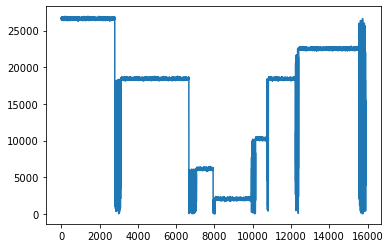

In [8]:
file=np.loadtxt('AR_00.txt')
pl.plot(file)

In [9]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    op=open(fname,'w')
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])
    op.write('\n')
    op.close()
    print('written process',p,'to ',fname)

Process 0 requires 9 pages and has a quality 0
[7, 6, 3, 3, 7, 1, 4, 7, 4] 23296
written process 0 to  AR_00.txt
Process 1 requires 11 pages and has a quality 3
[7, 1, 2, 2, 8, 1, 5, 7, 1, 0, 4] 30286
written process 1 to  AR_01.txt
Process 2 requires 9 pages and has a quality 0
[3, 7, 1, 8, 5, 1, 3, 1, 8] 17235
written process 2 to  AR_02.txt
Process 3 requires 9 pages and has a quality 3
[7, 2, 5, 2, 6, 6, 3, 4, 0] 18581
written process 3 to  AR_03.txt
Process 4 requires 7 pages and has a quality 0
[1, 1, 6, 5, 2, 5, 5] 19108
written process 4 to  AR_04.txt


23295


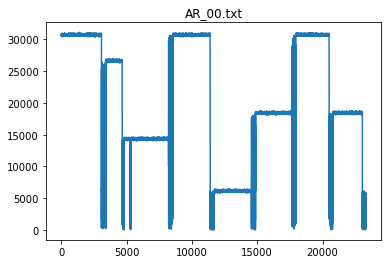

30286


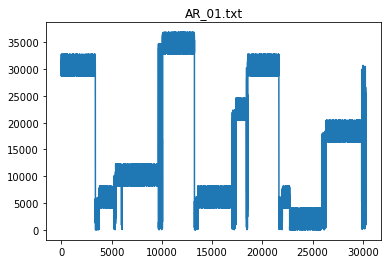

17234


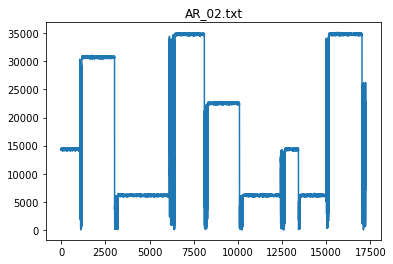

18581


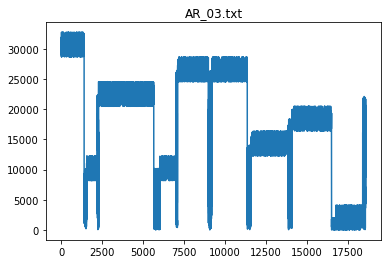

19107


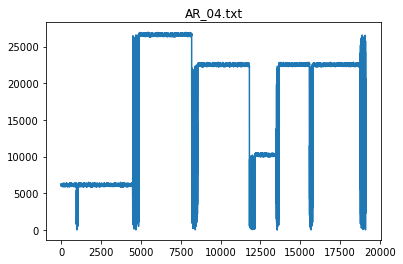

In [10]:
for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    temp=np.loadtxt(fname)
    print(len(temp))
    pl.plot(range(len(temp)),temp)
    pl.title(fname)
    pl.show()

In [11]:
def init_phys_mem():
    for i in range(F):           
        phys_mem[i,PID]=INVALID      #Initialize physical memory PID with empty
        phys_mem[i,FRAME]=INVALID    #Initialize physical memory frame with empty
        
init_phys_mem()

In [12]:
def update_phys_mem(pid):
    for i in range(F):                     
        if phys_mem[i,PID]==pid:
            #Execute the particular process  in that frame and make memory
            #available for other processes.
            
            phys_mem[i,PID]=INVALID        
            phys_mem[i,FRAME]=INVALID      

            
def memory_manager(infile,outfile,pid):
    num_adr=512+int(4096*np.random.random())
    idx=0 #counter to increase and read addresses.
    
    while idx<num_adr:
        add_ref=infile.readline().strip() #This will load all the address line by line
                                        #Also considered as virtual addresses.
        if add_ref=='':
            break #Finished reading address references
            
        add_ref=int(add_ref)  #Address reference
        pg_num=int(add_ref/PAGE_SIZE) #Page number to keep track of
        pg_offset=add_ref%PAGE_SIZE #Page offset.
        pg_base,pg_fault=get_pageframe(pg_num,pid) #Get page offset and page fault if occured 
                                                    #eslse initialize page for memory
        
        if pg_base>=0:
            phys_addr=pg_base+pg_offset            #Generating a physical address by adding both.
            outfile.write(str(add_ref)+','+str(phys_addr)+','
                         +str(pg_fault)+'\n')      #Copy logical address, physical address along 
                                                    #with page fault status in out file.
            
            if pg_fault==0:                #If returned value is 0 i.e load from memory.
                pr_timing[pid]+=IN_MEMORY
                #This is responsible for executing and storing time that 
                #is taken if no page fault occured
                
                
            elif pg_fault==1:              #IF returned value is 1 i.e memory fault occured
                pr_timing[pid]+=MEM_FAULT
                #If page fault occured it added time that is taken for process
                # execute
                
                
            else:
                pr_timing[pid]+=PAGE_REPLACE #Page replacement algo being run.
                #This time is responsible for replacing page and executing
                #particular process.
                
        else:
            print(idx)
            return INVALID
        idx+=1
    
    if idx>=num_adr:
        return INCOMPLETE
    
    return COMPLETED
            

def get_pageframe(pnum, pr) :
    fr_num = 0  #Initialize frame number to 0
    while fr_num < F : #Loop until counter reaches to all frames
        if phys_mem[fr_num,PID] == pr and phys_mem[fr_num,FRAME] == pnum : #if process is found in a frame, stop loop
            break                                                          #and keep track of frame number
        else :
            fr_num += 1  #Increase counter for frame

    if fr_num < F : #If the searched frame number is less than the available frames,
        return fr_num * PAGE_SIZE, 0 #Return frame number x 4096 i.e page base with page fault 0 i.e fault didnt occur.
                                    # Required page is in main memory and execute process.
    fr_num = gen_pagefault(pnum, pr) #Since frame number was greater than frame size so generate page fault.
                                    #So search for the frame and try to load in physical memory
    
    if fr_num>=0:  #check for the frame number returned from pagefault and return page fault occured once.
        return fr_num*PAGE_SIZE,1
    
    fr_num=page_replace(pnum,pr) #Running page replacement algorithm. Since page has to be 
                                #Loaded into physical memory.
    
    if fr_num>=0: 
        return fr_num*PAGE_SIZE,2 #This is to replace the page into main memory
    
    return INVALID,0 #If the required frame is not found, return Invalid
    
    
    
def gen_pagefault(pgnum, pr) :
    fr_num = 0 #Initialize frame number to 0
    while fr_num < F and phys_mem[fr_num,FRAME] >= 0 : #Loop untill frame number is not less than Frame number
        #and physical memory's frame number,Frame index >=0 i.e valid. It is searching for a page
        #inside main memory.  This is to check whether hit or fault is occured or not.
            
        fr_num += 1                                    # Increment frame number.
    
    if fr_num >= F :  #If frame number is greater than Frame Size than its Invalid i.e it is not present in memory.
        return INVALID
    
    #If fault didnt occur than  update physical memory and execute the process
    phys_mem[fr_num,FRAME] = pgnum     #Update physical memory with current page number
    phys_mem[fr_num,PID] = pr          #update physical memory with current process id
    
    return fr_num                      #return frame number in which Hit was occured.
        

  
def get_oldest_frame(pr,algo_type):
    global oldest_frame              #Access to the variable global_frame assigned
    if algo_type==FIFO_GLOBAL:      #IF algorithm is FIFO GLOBAL ,
        rv=oldest_frame            #temporary variable to store value of oldest_frame
        oldest_frame+=1           #Increase the value of oldest frame by 1 as it is accessed once
        if oldest_frame==F:      # If oldest frame reaches to max, again make it 0 to start
            oldest_frame=0       #So as to form a cycle and make frame available to all process
        return rv
    return INVALID
    



def page_replace(pgnum,pr,algo=FIFO_GLOBAL):
    current_frame=get_oldest_frame(pr,algo)  #Get track of previous frame so as to update the last
                                            #Frame in which process was executed and replace that 
                                            #with the new process to execute.
    phys_mem[current_frame,PID]=pr          #Update physical memory and execute process with the 
                                            #Current process ID.
    phys_mem[current_frame,FRAME]=pgnum     #Update physical memory and execute process with the 
                                            #Current page number.
    return current_frame                    #Return current frame in which page was loaded.

    
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F):                 #Run for loop for 16 times and print status of all
        if phys_mem[i,PID]!=INVALID:
            print('{:^10d} {:^6d} {:^6d}'.format(i,phys_mem[i,PID],phys_mem[i,FRAME]))
        else:
            print('Free Frame: ',i)
    

    
def ready_queue(q):  #Trying to read processes from ready queue
    while True:
        try:
            yield q.get_nowait()    #Try to get the process from queue
        except queue.Empty:
            break                   #If the queue is empty, Break.
    
print_phys_mem()


  Frame     PID   Page No.
  -----     ---   --------
Free Frame:  0
Free Frame:  1
Free Frame:  2
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Frame:  6
Free Frame:  7
Free Frame:  8
Free Frame:  9
Free Frame:  10
Free Frame:  11
Free Frame:  12
Free Frame:  13
Free Frame:  14
Free Frame:  15


In [13]:
init_phys_mem()
oldest_frame=0
pr_que=init_proc_queue()
pr_timing=np.zeros(F).astype('int32')
IN_MEMORY=1
MEM_FAULT=50
PAGE_REPLACE=100

infiles=list()
outfile=list()

for i in range(NP):
    fname = 'AR_{:02d}.txt'.format(i)
    outname = 'AR_{:02}_out.txt'.format(i)
    if os.access(fname,os.R_OK):
        print(f'Reading Process from {fname}')
        infiles.append(open(fname,'r'))
    else:
        print(f'Cannot open {fname} for reading')
    outfile.append(open(outname,'w'))
for pr in ready_queue(pr_que):
    rv=memory_manager(infiles[pr],outfile[pr],pr)
    if rv==INVALID:
        print('Memory overflow error')
        break
    if rv==INCOMPLETE:
        pr_que.put_nowait(pr)
    else:
        print(f'Process {pr} (Size:{pr_size[pr]} Bytes) Completed;\
        removing from Queue')
        slow=((pr_timing[pr]-pr_size[pr])*100.0/pr_size[pr])
        print(f'Slow down by {slow}')
        update_phys_mem(pr)
        print_phys_mem()

[1, 2, 4, 3, 0]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Process 2 (Size:17235 Bytes) Completed;        removing from Queue
Slow down by 18.926602843051928
  Frame     PID   Page No.
  -----     ---   --------
Free Frame:  0
Free Frame:  1
Free Frame:  2
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Frame:  6
    7        1      1   
    8        1      5   
    9        1      6   
    10       1      4   
    11       1      2   
    12       1      3   
    13       1      8   
Free Frame:  14
Free Frame:  15
Process 3 (Size:18581 Bytes) Completed;        removing from Queue
Slow down by 19.69754049835854
  Frame     PID   Page No.
  -----     ---   --------
    0        4      0   
    1        4      4   
    2        4      3   
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Frame:  6
Free Frame:  7
Free Frame:  8
    9        0      7   
    10       1      7 

In [14]:
for i in range(NP) :
    infiles[i].close()
    outfile[i].close()

In [15]:
# Command to execute 
# Using Windows OS command 
cmd = 'notepad'
  
# Using os.system() method 
# os.system(cmd)

# How System Call Works?
Here are steps for System Call:

In [16]:
Image(url='https://www.guru99.com/images/1/121119_0451_SystemCalli2.png')

In [17]:
Image(url='https://www.guru99.com/images/1/121119_0451_SystemCalli3.png')

Step 1) The processes executed in the user mode till the time a system call interrupts it.

Step 2) After that, the system call is executed in the kernel-mode on a priority basis.

Step 3) Once system call execution is over, control returns to the user mode.,

Step 4) The execution of user processes resumed in Kernel mode.

Why do you need System Calls in OS?
Following are situations which need system calls in OS:

Reading and writing from files demand system calls.
If a file system wants to create or delete files, system calls are required.
System calls are used for the creation and management of new processes.
Network connections need system calls for sending and receiving packets.
Access to hardware devices like scanner, printer, need a system call.

# Types of System calls


In [18]:
Image(url='https://www.guru99.com/images/1/121119_0451_SystemCalli4.png')

## Process Control

## File Management

## Device Management

## Information Maintenance

## Communication:

## Rules for passing Parameters for System Call

# Important System Calls Used in OS

### wait()

### fork()

### exec()

### kill():

### exit():

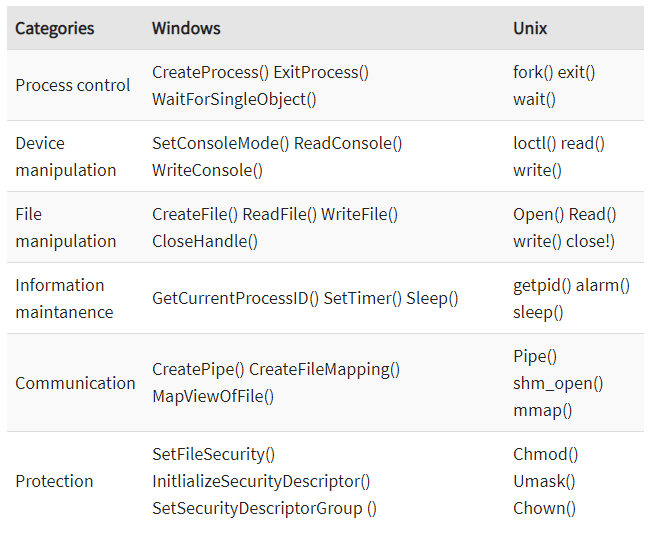

In [19]:
Image(filename='summary.png')

### Program to open notepad using a system call

In [20]:
command='notepad'

In [21]:
fname=command+'.txt'
op=open(fname,'w')
npg=int(np.random.normal(10,2.5))
nsig=int(5*np.random.random())
print(f'Process {fname} requires {npg} pages and has a quality {nsig}')
pg_seq,pr_size[p]=sim_process(npg,nsig,op)
print(pg_seq,pr_size[p])
op.write('\n')
op.close()
print('written process',p,'to ',fname)

Process notepad.txt requires 9 pages and has a quality 2
[5, 0, 6, 8, 3, 4, 7, 2, 4] 25138
written process 4 to  notepad.txt


In [22]:
outfile=open('notepad_out.txt','w')
rv=memory_manager(open('notepad.txt','r'),outfile,10)
outfile.close()
print(rv)

20


In [23]:
512 + int(4096 * np.random.random())

1482

In [24]:
# os.system('notepad')

In [25]:
#Creating some random strings that are considered as instrucions to be
#executed. 
#0 indicates short system call i.e it executes properly.
#1 indicates long system call where scheduler comes into action
#2 indicates IO system call where process goes into wait state 

letters=list('abcdefghijklmnopqrstuvwxyz')
letters=[ord(i) for i in letters]
print(letters)

temp0=np.array([[''.join([chr(i) for i in np.random.choice(letters,np.random.randint(3,10))]),np.random.randint(1,100),np.random.randint(1,50),np.random.randint(0,1)] for i in range(800)],dtype='O')
temp1=np.array([[''.join([chr(i) for i in np.random.choice(letters,np.random.randint(3,10))]),np.random.randint(1,100),np.random.randint(1,50),np.random.randint(1,3)] for i in range(200)],dtype='O')
temp=np.append(temp0,temp1,axis=0)
np.random.shuffle(temp)
temp[:10]

# 1st param is process id
# 2nd param is arrival time
# 3rd param is burst time
# 4th param is unique id to recognize type of system call

[97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


array([['mmgtgumse', 22, 5, 0],
       ['alekj', 94, 35, 0],
       ['ruk', 18, 15, 0],
       ['bucju', 20, 21, 0],
       ['cnug', 44, 26, 0],
       ['qelbgy', 18, 30, 2],
       ['sqxxgkwce', 40, 13, 0],
       ['zqnmtd', 33, 4, 2],
       ['fhrnhk', 6, 28, 2],
       ['fmxkwj', 55, 42, 0]], dtype=object)

In [26]:
print('{:^20s} {:^10s} {:^10s} {:^10s}'.format('Process','Arrival_t','Burst_t','Sys_call'))
print('{:^20s} {:^10s} {:^10s} {:^10s}'.format('----------','----------','----------','----------'))
for i in temp[:5]:
    print('{:^20s} {:^10d} {:^10d} {:^10d}'.format(i[0],i[1],i[2],i[3]))


      Process        Arrival_t   Burst_t    Sys_call 
     ----------      ---------- ---------- ----------
     mmgtgumse           22         5          0     
       alekj             94         35         0     
        ruk              18         15         0     
       bucju             20         21         0     
        cnug             44         26         0     


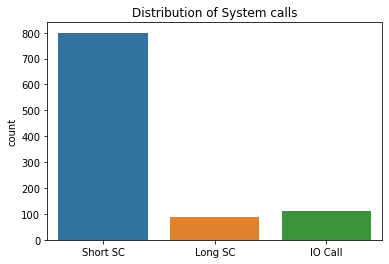

In [27]:
pl.title('Distribution of System calls')
sns.countplot(np.array(temp)[:,3])
pl.xticks(range(3),['Short SC','Long SC','IO Call'])
pl.show()

In [28]:
print(f"There are {np.unique(np.array(temp)[:,0],return_counts=True)[1].sum()} unique processes")

There are 1000 unique processes


In [29]:
#Here instead of passing whole process as a list,passing index of that process would be a better idea

def fix_burst(process):
    df=pd.DataFrame(process,columns=['Process','Arrival_t','Burst_t','Sys_call'])
    tmp=df['Burst_t'].values.copy()
    for i in range(len(tmp)):
        if df['Sys_call'].values[i]==0 and tmp[i]>20:
            tmp[i]=int(tmp[i]/np.random.randint(4,9))
    df['Burst_t']=tmp
    return df.values


def readyQueue(pr):
    print('--------------------------------------------------------------------')
    print(f"Process is Long SC so {pr} added to queue")
    #Process after initialized goes to ready Queue which is ready for execution.
    ready_state.append(pr)
    print(ready_state)

    
    
def waitState(pr):
    print('--------------------------------------------------------------------')
    print(f'Process {pr} is an IO call so made it wait')
    #Here IO call has occured and process goes to wait_state.
    wait_state.append(pr)
    print('Waiting Queue',wait_state)
    
def returnProcess(process):
    return process.pop(0)

def run_process(data):
    print('--------------------------------------------------------------------')
    print(f"Execute process {data}")
    
def sim(procsSS):
    for i in range(20):
        if procsSS[i][3]==0:
            run_process(procsSS[i][0])
            time.sleep(0.4)
        if procsSS[i][3]==1:
            readyQueue(procsSS[i][0])
            time.sleep(0.4)
        if procsSS[i][3]==2:
            waitState(procsSS[i][0])
            time.sleep(0.4)
    print("Executing processes those were in ready state")
    while len(ready_state)!=0:
        p=returnProcess(ready_state)
        run_process(p)
        time.sleep(0.4)
    print("Executig processes those were in wait state")
    while len(wait_state)!=0:
        p=returnProcess(wait_state)
        run_process(p)
        time.sleep(0.4)
        
        
process=[]
wait_state=[]
ready_state=[]
procsSS=fix_burst(temp)
sim(procsSS)

<IPython.core.display.Javascript object>

--------------------------------------------------------------------
Execute process mmgtgumse
--------------------------------------------------------------------
Execute process alekj
--------------------------------------------------------------------
Execute process ruk
--------------------------------------------------------------------
Execute process bucju
--------------------------------------------------------------------
Execute process cnug
--------------------------------------------------------------------
Process qelbgy is an IO call so made it wait
Waiting Queue ['qelbgy']
--------------------------------------------------------------------
Execute process sqxxgkwce
--------------------------------------------------------------------
Process zqnmtd is an IO call so made it wait
Waiting Queue ['qelbgy', 'zqnmtd']
--------------------------------------------------------------------
Process fhrnhk is an IO call so made it wait
Waiting Queue ['qelbgy', 'zqnmtd', 'fhrnhk']
--

In [42]:
procsSS[:20]

array([['mmgtgumse', 22, 5, 0],
       ['alekj', 94, 4, 0],
       ['ruk', 18, 15, 0],
       ['bucju', 20, 2, 0],
       ['cnug', 44, 3, 0],
       ['qelbgy', 18, 30, 2],
       ['sqxxgkwce', 40, 13, 0],
       ['zqnmtd', 33, 4, 2],
       ['fhrnhk', 6, 28, 2],
       ['fmxkwj', 55, 7, 0],
       ['aeqdwcb', 61, 10, 0],
       ['slzdsse', 29, 6, 0],
       ['ebpm', 65, 26, 2],
       ['jaiiptfc', 37, 20, 0],
       ['jlynr', 53, 7, 0],
       ['mcopscb', 96, 18, 2],
       ['sfnngbzon', 52, 4, 0],
       ['cytg', 78, 6, 1],
       ['gytxqtg', 18, 2, 0],
       ['ymf', 98, 5, 0]], dtype=object)

In [53]:
class Process:
    def __init__(self,pid,at,bt,inloc,outloc):
        self.pid=pid
        self.at=at
        self.bt=bt
        self.inloc=inloc
        self.outloc=outloc
        
    def processId(self):
        return self.pid
        
    def arrivalTime(self):
        return self.at
    
    def burstTime(self):
        return self.bt
    
    def inLoc(self):
        return self.inloc
    
    def outLoc(self):
        return self.outloc

In [69]:
Image(url='https://prepinsta.com/wp-content/uploads/2019/08/Process-1024x597.png')

In [73]:
processes=[]
for i in range(5):
    temp_p=Process(i,np.random.randint(1,10),np.random.randint(1,10),'infile{:d}'.format(i)+'.txt','outfile{:d}'.format(i)+'.txt') 
    processes.append(temp_p)
    op = open(temp_p.inLoc(), 'w')
    npg = int(np.random.normal(10,2.5))
    nsig = int(5 * np.random.random())
    print(f'Process {temp_p.processId()} requires {npg} pages and has a quality {nsig}')
    pg_seq, pr_size[p] = sim_process(npg, nsig, op)
    print(pg_seq, pr_size[p])
    op.write('\n')
    op.close()
    print('Written process ', p, 'to ', fname)

Process 0 requires 11 pages and has a quality 2
[4, 8, 8, 8, 2, 4, 5, 0, 5, 5, 2] 27498
Written process  4 to  notepad.txt
Process 1 requires 9 pages and has a quality 1
[8, 7, 0, 6, 0, 0, 7, 8, 1] 23995
Written process  4 to  notepad.txt
Process 2 requires 8 pages and has a quality 2
[4, 0, 0, 0, 6, 1, 3, 4] 19279
Written process  4 to  notepad.txt
Process 3 requires 9 pages and has a quality 0
[8, 3, 3, 8, 0, 4, 3, 8, 0] 18622
Written process  4 to  notepad.txt
Process 4 requires 12 pages and has a quality 2
[3, 0, 9, 6, 0, 6, 10, 7, 0, 10, 9, 8] 32105
Written process  4 to  notepad.txt


In [74]:
processes[0].processId(),processes[1].processId(),processes[2].processId(),processes[3].processId()

(0, 1, 2, 3)

In [75]:
processes[0].burstTime(),processes[1].burstTime(),processes[2].burstTime(),processes[3].arrivalTime()

(6, 3, 2, 5)

In [76]:
processes[0].inLoc(),processes[1].inLoc(),processes[2].inLoc(),processes[3].inLoc()

('infile0.txt', 'infile1.txt', 'infile2.txt', 'infile3.txt')

In [77]:
processes[0].outLoc(),processes[1].outLoc(),processes[2].outLoc(),processes[3].outLoc()

('outfile0.txt', 'outfile1.txt', 'outfile2.txt', 'outfile3.txt')

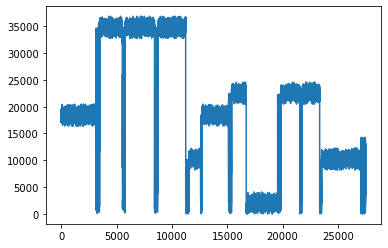

In [80]:
pl.plot(np.loadtxt(processes[0].inLoc()))

In [97]:
def new(pr):
    pass

def LongSystemcallQueue(pr):
    longSysCallprocess.append(pr)

def ready_queue(pr):
    return processes.pop(0)   
    
def wait_queue(pr):
    waiting_processes.append(pr)
    


ready_processes=[]
waiting_processes=[]
longSysCallprocess=[]


In [96]:
a=[]
a.append(1)
a.append(2)
print(a.pop(0))

1
